#### <span style="color:#AD07FF"> In this notebook you can see data cleaning, visualization, hypothesis testing,  <br> adding new features and preparing data so that we can run a model.

# <span style="color:#FF7B07"><div align="center">**Table Of Contents**
[<span style="color:#FF7B07">**1. Introduction**](#1)<br>
[<span style="color:#FF7B07">**2. Import Libraries and Load Data**](#2)<br>
[<span style="color:#FF7B07">**3. Data Analysis**](#3)<br>
[<span style="color:#FF7B07">**4. Create Features**](#4)<br> 
[<span style="color:#FF7B07">**5. Data Cleaning**](#5)<br>
[<span style="color:#FF7B07">**6. Data Preparation**](#6)<br> 

# <span style="color:#FF7B07"><div align="center">**Introduction** <a  name="1"></a>

Nowadays, a healthy lifestyle is becoming a valuable characteristic of a modern society. <br>
More and more people try to enhance their health by doing regularly different sports and put emphasis on their food habits. <br>
In order to satisfy the specific needs of every individual, conclusions gained out of the users’ data are from high importance. <br>
Companies such as MyFitnessPal operate in the lucrative business field of health data. <br>
The healthcare industry is booming, especially when it comes to the analysis of health-related data. <br>
This report will show how the analysis of data will improve the life of the users, <br>
but also highlight the potential for companies active in the business. <br>
#### <span style="color:#FF7B07">  **Source** https://www.kaggle.com/vetrirah/customer?select=Train.csv

# <span style="color:#FF7B07"><div align="center">**Import Libraries and Load Data** <a  name="2"></a>

In [1]:
from datetime import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn import preprocessing

In [2]:
# The data is large and this command will help us to see the whole result 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
data = pd.read_csv('myFitnessPal_parsed.csv')

In [4]:
# with open('foods.json') as json_file:
#      foods = json.load(json_file)

# <span style="color:#FF7B07"><div align="center">**Data Analysis** <a  name="3"></a>

#### <span style="color:#FF7B07">Let us first review the general information of the data 

In [5]:
print(f'\n Data shape - {data.shape} ')
print(f' Unique users - {data["user_id"].nunique()} \n')
data.head(3)



 Data shape - (2073989, 16) 
 Unique users - 9896 



,user_id,date,sequence,food_ids,total_calories,total_carbs,total_fat,total_protein,total_sodium,total_sugar,goal_calories,goal_carbs,goal_fat,goal_protein,goal_sodium,goal_sugar
0,1,2014-09-15,1,"[1, 2, 3, 4, 4]",2430,96,37.0,50.0,855.0,63.0,1572.0,196.0,52.0,79.0,2300.0,59.0
1,1,2014-09-16,1,"[5, 1, 2, 3, 6, 7]",1862,158,54.0,114.0,2215.0,100.0,1832.0,229.0,61.0,92.0,2300.0,69.0
2,1,2014-09-17,1,"[1, 2, 3, 6, 8, 9, 10]",2251,187,60.0,98.0,1765.0,105.0,1685.0,210.0,56.0,85.0,2300.0,63.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2073989 entries, 0 to 2073988
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   user_id         int64  
 1   date            object 
 2   sequence        int64  
 3   food_ids        object 
 4   total_calories  int64  
 5   total_carbs     int64  
 6   total_fat       float64
 7   total_protein   float64
 8   total_sodium    float64
 9   total_sugar     float64
 10  goal_calories   float64
 11  goal_carbs      float64
 12  goal_fat        float64
 13  goal_protein    float64
 14  goal_sodium     float64
 15  goal_sugar      float64
dtypes: float64(10), int64(4), object(2)
memory usage: 253.2+ MB


#### <span style="color:#00CC00"> As you can see most of the feature's type is number so we don't need to convert them <br>  except "date" and "food_ids" which needs to converted.

In [7]:
data.describe()

,user_id,sequence,total_calories,total_carbs,total_fat,total_protein,total_sodium,total_sugar,goal_calories,goal_carbs,goal_fat,goal_protein,goal_sodium,goal_sugar
count,2.073989e+06,2.073989e+06,2.073989e+06,2.073989e+06,2.071591e+06,2.071591e+06,2.070214e+06,2.070207e+06,2.068044e+06,2.068032e+06,1.978417e+06,1.978409e+06,1.831915e+06,1.830989e+06
mean,4.961839e+03,2.749635e+00,1.546770e+03,1.688896e+02,7.679213e+01,1.059763e+02,1.226454e+03,4.512624e+02,1.639615e+03,1.967361e+02,9.049824e+01,1.617011e+02,1.417929e+03,4.281487e+02
std,2.841763e+03,1.444130e+00,1.853027e+03,4.015440e+02,2.393573e+02,2.899013e+02,1.808091e+03,9.724071e+02,7.350886e+02,3.200250e+02,2.326547e+02,3.835158e+02,1.181494e+03,9.016912e+02
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.544000e+03,1.000000e+00,1.200000e+03,9.600000e+01,3.500000e+01,4.900000e+01,3.400000e+01,2.700000e+01,1.350000e+03,1.240000e+02,4.700000e+01,7.200000e+01,5.300000e+01,4.500000e+01
50%,4.939000e+03,3.000000e+00,1.493000e+03,1.490000e+02,5.300000e+01,7.400000e+01,8.620000e+02,5.800000e+01,1.660000e+03,1.800000e+02,5.900000e+01,9.800000e+01,2.300000e+03,6.500000e+01
75%,7.447000e+03,4.000000e+00,1.838000e+03,2.010000e+02,7.600000e+01,1.050000e+02,2.092000e+03,1.570000e+02,2.015000e+03,2.310000e+02,7.900000e+01,1.400000e+02,2.300000e+03,1.000000e+02
max,9.897000e+03,6.000000e+00,1.200800e+06,2.108650e+05,1.320880e+05,1.149490e+05,9.600000e+05,1.680150e+05,2.606800e+04,1.544170e+05,3.812800e+04,1.029450e+05,2.300900e+04,3.505500e+04


#### <span style="color:#00CC00"> At first glance we would probably see that data needs to be normalized and maybe we have some outliers too

#### <span style="color:#FF7B07"> As we know we have a different number of records for each user in the data 

In [8]:
print(f'user_id 1 has {len(data[data["user_id"]==1])} records')
print(f'user_id 2 has {len(data[data["user_id"]==2])} records')

user_id 1 has 173 records
user_id 2 has 213 records


#### <span style="color:#FF7B07"> User may also have missed information between the first and final days of the record

In [9]:
data[data["user_id"]==7].head(2)

,user_id,date,sequence,food_ids,total_calories,total_carbs,total_fat,total_protein,total_sodium,total_sugar,goal_calories,goal_carbs,goal_fat,goal_protein,goal_sodium,goal_sugar
1612,7,2014-10-06,1,"[980, 981]",360,45,14.0,15.0,2.0,5.0,1400.0,140.0,31.0,140.0,25.0,102.0
1613,7,2014-10-15,1,[982],140,2,9.0,12.0,0.0,1.0,1400.0,140.0,31.0,140.0,25.0,102.0


#### <span style="color:#00CC00"> As we can see, User whose ID is 7, made the first record in 2014-10-06 and the second in 2014-10-15. <br> We will need to reflect this information as new feature

#### <span style="color:#FF7B07"> Check for null values in the data

In [10]:
null_df = pd.DataFrame(data.isna().sum())
null_df.columns = ["Null Frequency"]
null_df.T

,user_id,date,sequence,food_ids,total_calories,total_carbs,total_fat,total_protein,total_sodium,total_sugar,goal_calories,goal_carbs,goal_fat,goal_protein,goal_sodium,goal_sugar
Null Frequency,0,0,0,0,0,0,2398,2398,3775,3782,5945,5957,95572,95580,242074,243000


#### <span style="color:#00CC00"> As we saw there are 10 columns which have sometimes null values <br> User can have a maximum of 10 columns with null value <br> So I think we should throw away a user who has 4 or more Null values, <br> Because otherwise it would turn out that we have filled more than 25 percent of the user information

In [11]:
print('Users which have null in more than 3 columns : ',(len(data.loc[data.isnull().sum(axis=1)>3])/len(data))*100,'%')
nullColumns = data.loc[data.isnull().sum(axis=1)>3].index
nullColumns = pd.DataFrame(nullColumns,columns={'index'})

Users which have null in more than 3 columns :  4.608124729687573 %


#### <span style="color:#00CC00"> It seems that the number of such people is about 4.6 percent. <br> Due to the fact that the data is not so little and at the same time filling 4 null feature is not so accurate we can throw them 

#### <span style="color:#FF7B07"> There can still be a problem with the values and such a situation is when the goal calories are 0 <br>and the mentioned situation does not make sense <br> because the main purpose of the app is to select a goal and get closer to it.

In [12]:
print('Users which have zero in goal_calories : ',(len(data[data['goal_calories']==0])/len(data))*100,'%')

Users which have zero in goal_calories :  0.11137956855123148 %


#### <span style="color:#00CC00"> It seems that the number of such people is about 0.1 percent. So we can throw them away 

In [13]:
def createPlot(data, col:str, ttext:str, xtext:str, ytext:str) ->None:
    """
    this function creates histogram and boxplot by pyplot library and also count skewness
    
    Arguments:
    data -- pandas dataframe
    col -- column name which we want to plot
    ttext -- string which we want to write on top of the graph
    xtext -- string which we want to write on x axis
    ytext -- string which we want to write on y axis
    
    Returns:
    None
    """
    fig = make_subplots(rows=1, cols=2)
    fig.add_trace(go.Histogram(x=data[col],marker_color='#6a6fff'),row=1,col=1)
    fig.add_trace(go.Box(x=data[col]),row=1,col=2)
    
    fig.update_layout(
        title_text=ttext,
        xaxis_title_text=xtext,
        yaxis_title_text=ytext, 
        bargap=0.05, 
        template = 'plotly_dark',
        width=900, height=600
    )
    fig.add_annotation(dict(font=dict(color='yellow',size=15),
                                        x=0.35,
                                        y=1.1,
                                        showarrow=False,
                                        text="Skewness = "+str(data[col].skew()),
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))
    
    fig.show()
#createPlot(data,"goal_calories","Time Distribution","Time (days)","count")

In [14]:
# groups = ['Low','Medium','High']
# dfForPlot = df.copy();
# def get_categories(x):
#     if x < q1:
#         return groups[0]
#     elif x < q3:
#         return groups[1]
#     else:
#         return groups[2]    

# for col in numVariable:
#     q1 = df[col].quantile(q=0.25)
#     q3 = df[col].quantile(q=0.75)
#     dfForPlot[col] = df[col].apply(get_categories)

#### <span style="color:#FF7B07"> There are many spreaded Hypotheses about diet, healthy lifestyle and also about habits too. Now let's check their validity with our data

#### <span style="color:#FF7B07">  1. People more likely start diet and healthy lifestyle on mondays

In [15]:
daysCount=[0,0,0,0,0,0,0]
for ID in data['user_id'].unique():
    date = data[data["user_id"]==ID].head(1)['date'].values[0]
    d=datetime.strptime(str(date), "%Y-%m-%d")
    daysCount[d.weekday()]+=1

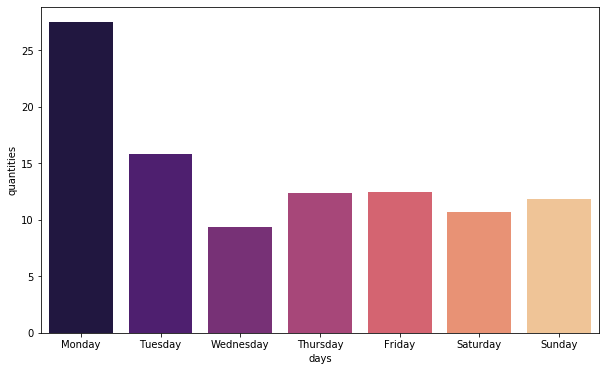

In [16]:
res = np.dot([i / np.sum(daysCount) for i in daysCount],100)
fig, ax = plt.subplots(figsize=(10,6))
df=pd.DataFrame({'days':['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],'quantities': res})
sns.barplot(x='days',y='quantities',data=df,palette='magma',ax=ax)

#### <span style="color:#00CC00"> The results show that hypothesis were right: <br>  people more likely start diet on mondays and the graph also proves that wednesday is really lazy day to start something. 

#### <span style="color:#FF7B07">  2. People frequently cheat diet on weekends

In [17]:
daysCount=[0,0,0,0,0,0,0]
daysLogged=[0,0,0,0,0,0,0]
for i,row in data.iterrows():
    date = row['date']
    goal_calories=row['goal_calories']
    total_calories=row['total_calories']
    if total_calories > (goal_calories+goal_calories*15) :  # actually total_calories more than approx. 5 hamburgers  😂 
        d=datetime.strptime(str(date), "%Y-%m-%d")
        daysCount[d.weekday()]+=1
    daysLogged[d.weekday()]+=1

In [18]:
res = [i / j for i, j in zip(daysCount,daysLogged)]
res =np.dot( [i / np.sum(res) for i in res],100)

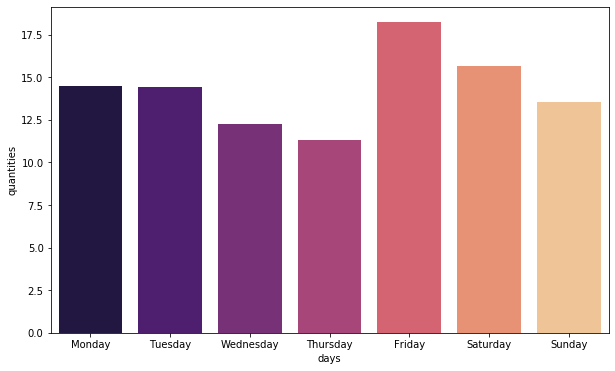

In [54]:
fig, ax = plt.subplots(figsize=(10,6))
df=pd.DataFrame({'days':['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],'quantities': res})
sns.barplot(x='days',y='quantities',data=df,palette='magma',ax=ax)

#### <span style="color:#00CC00"> Looks like people use to cheat on fridays and saturdays more, they took much more calories on these days. Our hypothesis partially justified

#### <span style="color:#FF7B07">  3. 77 percent of users never use an app again 72 hours after installing

In [83]:
apps_log=pd.DataFrame()
apps_log["days_used_app"] = data["user_id"].value_counts()
apps_log["people"] = apps_log["days_used_app"].apply(lambda x: len(apps_log[apps_log["days_used_app"]==x]))

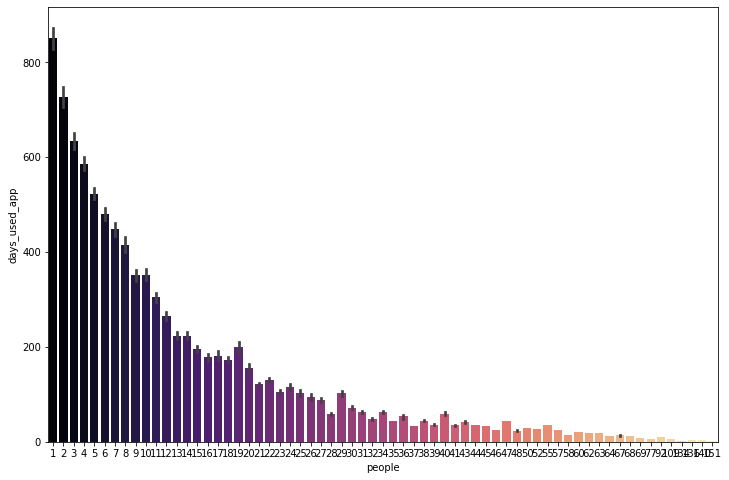

In [84]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='people',y='days_used_app',data=apps_log,palette='magma',ax=ax)

#### <span style="color:#00CC00"> Hypothesis is partly correct, not only 3 days but it's usage reduces exponentially. It takes users almost 1 month to surrender. Maybe it's the period they reach dreamy weight

#### <span style="color:#FF7B07"> Now look at the nutrients individually as taking extra nutrients can be dangerous For example taking too much sugar can cause diabetes <br> Let's draw total and goal nutrients together and see how many percentage is under or above risk <br> Based on this information we can tell the customer to reduce consumption or increase it depending on whether he is at risk or not. 

In [ ]:
def plot_nutrient(df,nutrient_name,goal_nutrient_name,thr1,thr2):
    """
    This function creates 3 plots based on thresholds
    
    Arguments:
    df -- pandas dataframe
    nutrient_name -- column name which we want to plot
    goal_nutrient_name -- column name which we want to plot
    thr1 -- threshold on the values below which we draw the first drawing   
    thr2 -- threshold on the values above which we draw the third drawing
    
    Returns:
    None
    """
    avg = df.groupby(['user_id']).apply(lambda x: x[nutrient_name].sum()/len(x)).reset_index()
    goal = df.groupby(['user_id']).apply(lambda x: x[goal_nutrient_name].sum()/len(x)).reset_index()
    avg.columns = ["user_id", "avg_nut"]
    goal.columns = ["user_id", "goal_avg_nut"]

    fig, ax =plt.subplots(1,3,figsize=(17,7))
    _max = max(df[nutrient_name].max(),df[goal_nutrient_name].max())
    ax[0].hist(avg[avg['avg_nut']<thr1]['avg_nut'], range=[0,thr1], color='Red', fc='none', lw=2, histtype='step')
    ax[0].hist(goal[goal['goal_avg_nut']<thr1]['goal_avg_nut'], range=[0,thr1], color='Green', fc='none', lw=2, histtype='step')
    ax[0].legend(('Total', 'Goal'), loc="upper right")
    ax[1].hist(avg['avg_nut'], range=[thr1,thr2], color='Red',fc='none', lw=2, histtype='step')
    ax[1].hist(goal['goal_avg_nut'], range = [thr1,thr2], color='Green', fc='none', lw=2, histtype='step')
    ax[1].legend(('Total', 'Goal'), loc="upper right")
    ax[2].hist(avg[avg['avg_nut']>thr2]['avg_nut'], range=[thr2,_max], color='Red', fc='none', lw=2, histtype='step')
    ax[2].hist(goal[goal['goal_avg_nut']>thr2]['goal_avg_nut'], range=[thr2,_max], color='Green', fc='none', lw=2, histtype='step')
    ax[2].legend(('Total', 'Goal'),loc="upper right")
    
    under_minimum = len(avg[avg['avg_nut'] < thr1])
    above_minimum = len(avg[avg['avg_nut'] > thr2])
    total = avg.user_id.nunique()

    print(f'\nlower risk group: {100*under_minimum/total} %')
    print(f'above risk group: {100*above_minimum/total} %')
    print(f'not   risk group: {100*(1-(under_minimum+above_minimum)/total)} %\n')

In [ ]:
user_tenure = data['user_id'].value_counts().to_frame().reset_index()
user_tenure.columns = ['user_id', 'Amount']

top_users = pd.merge(data, user_tenure.head(1000), on='user_id', how='inner')

In [ ]:
plot_nutrient(top_users,"total_sugar","goal_sugar",50,350)

In [ ]:
plot_nutrient(top_users,"total_carbs","goal_carbs",50,350)

#### <span style="color:#FF7B07"> Let's see what food they eat most often in month. <br> This information can be used by markets to determine how many products they should receive per month 

In [ ]:
def add_elem_dict(all_names,lst):
    for food_id in lst[1:-1].split(","):
        food_id = food_id.replace(' ','')
        all_names[food_id] = all_names.get(food_id,0)+1
        
def get_top_food_ids(df,top_numbers):
    all_names = {}
    df["food_ids"].apply(lambda lst: add_elem_dict(all_names,lst))
    top_food_ids = list(sorted(all_names.items(), key=lambda item: item[1]))
    top_food_ids = [key for key,value in top_food_ids]
    top_food_ids.reverse()
    return top_food_ids[:10]

In [ ]:
data["month"] = data["date"].apply(lambda x: x[5:7])
max_food_in_month = data.groupby(['month']).apply(lambda x: get_top_food_ids(x,10))
del data["month"]

top_food_dataframe = pd.DataFrame(max_food_in_month)
top_food_dataframe = top_food_dataframe.apply(lambda x: x[0], axis = 1, result_type ='expand').reset_index()
top_food_dataframe.columns = ["month","meal_1","meal_2","meal_3","meal_4","meal_5","meal_6","meal_7","meal_8","meal_9","meal_10"]

In [ ]:
for col in top_food_dataframe.columns[1:]:
    top_food_dataframe[col] = top_food_dataframe[col].apply(lambda food_id: foods[str(int(food_id))])

In [ ]:
top_food_dataframe

#### <span style="color:#00CC00"> As we can see, Strawberries - Raw is in the top products after January <br> and every month it increases its popularity until May and then the amount of its use decreases again which is logical 

# <span style="color:#FF7B07"><div align="center">**Create Features** <a  name="4"></a>

In [ ]:
data.head(3)

#### <span style="color:#00CC00"> As we see one feature which needs to be remaked is food_ids <br> So, we will extract most of the information from the given feature and create a new one <br> so that we can lose as few information as possible.<br> Firstly, we'll create a new attribute based on the size of food_ids . 

In [ ]:
data['foods_len'] = data["food_ids"].apply(lambda x: len(x[1:-1].split(',')))

In [ ]:
# createPlot(data,"foods_len","Foods len Dist","Foods length","count")

✔️ Foods_len is right skewed (0.8). <br>
❌ There are a few outliers in the distribution. <br>
✔️ Most of the applicant's foods_len is near 10 <br> 
❌ Max number of foods in one day is 62 <br>
✔️ Min number of foods in one day is 1

#### <span style="color:#FF7B07"> For each user we may have several rows. <br> Our goal is to transform the data so that we have one characteristic or one row for each person. <br> So let's take a separate feature of how many records we have for each person. <br> It will also help us to store information and according to the algorithm we can select people who for example have less than 10 records

#### <span style="color:#FF7B07"> To do this,we create temporary dataframe where we will have unique user IDs and the corresponding number of logs<br>  so that we do not want the values to be repeated and data manipulation to become difficult. <br> Finally after we prepare the data we will add it and we will have all the columns together so do not be confused 

In [ ]:
# add new feature which shows how many days are logged by each applicants
user_logged_freq = data["user_id"].value_counts()
user_logged_df = pd.DataFrame(data["user_id"].unique(),columns = ['user_id'])
user_logged_df["logged_frequency"] = user_logged_df["user_id"].apply(lambda _id: user_logged_freq[_id])

In [ ]:
# createPlot(user_logged_df,"logged_frequency","logged Distribution","logged","count")

✔️ logged frequency is right skewed (0.8). <br>
✔️ There are no outliers in the distribution. <br>
✔️ Most of the logged frequency is near 42 <br> 
✔️ Max number of logs is 187 <br>
❌ Max number of logs is 1

#### <span style="color:#00CC00"> It seems that there are people who have 187 records and also people with 1 record

#### <span style="color:#FF7B07"> As we saw, users may have missed data between start and end date, <br> so let's do a separate feature to show that <br> This will help us retain as much information as possible about our customers

In [ ]:
# this function counts whole days between start and end date and calculates missed days for new feature
def days_missed(d1, d2,loggedDays):
    d1 = datetime.strptime(str(d1), "%Y-%m-%d")
    d2 = datetime.strptime(str(d2), "%Y-%m-%d")
    return abs(abs((d2 - d1).days)-loggedDays)

In [ ]:
# this function calls days_missed regarding last and first records
def get_missed_days(df,userID,logged_frequency):
    tail = df[df["user_id"]==userID].tail(1)['date'].values[0]
    head = df[df["user_id"]==userID].head(1)['date'].values[0]
    return days_missed(tail,head,logged_frequency)   

In [ ]:
# add new feature based on how many days are missed for each user
user_logged_df['days_missed'] = user_logged_df[['user_id','logged_frequency']].apply(lambda x: get_missed_days(data,x.user_id,x.logged_frequency),axis=1)

In [ ]:
# createPlot(user_logged_df,"days_missed","Missing days Distribution","Missing days","count")

✔️ Missing days is right skewed (0.4). <br>
✔️ There are no outliers in the distribution. <br>
❌ Most of the Missing frequency is near 48 <br> 
❌ Max number of logs is 174 <br>
✔️ Max number of logs is 1

#### <span style="color:#FF7B07"> Since the data relates to nutrition, health and exercise, <br>we need to have a separate variable for each row <br> that shows user's nutritions ratio satisfies the known dependence. If it's in accepted norm, we call it healthy distributed.

In [ ]:
def getHealtyDistributedValues(value,lower,upper):
    if(value <= lower):
        return lower-value # the difference person lacked 
    if(value >= upper):
        return value-upper # the difference person exceed 
    return 0 # method returns 0 for the values in range

In [ ]:
# There is known that for healthy eating, daily carbs should be between 45-65% out of callories, fats between 10-35% and proteins 20-35%
# So this method counts daily norm distribution of person
# 0 for the people in persmissible range
# max value may be 1.3 (when person only took fats)

def healthyDistributed(carbs,fat,protein):
    totalCalories = fat*9+ carbs*4 + protein*4 # convert to calories (1g fat = 9 calories and etc..) and sum
    sum =  getHealtyDistributedValues ( carbs*4 / (totalCalories+0.00000001),0.45,0.65)
    sum += getHealtyDistributedValues ( protein*4 / (totalCalories+0.00000001),0.2,0.35)
    sum += getHealtyDistributedValues ( fat*9 / (totalCalories+0.00000001),0.1,0.35)
    return sum

In [ ]:
data['healtyDistrib'] = data[['total_carbs','total_fat','total_protein']].apply(lambda x: healthyDistributed(x.total_carbs,x.total_fat,x.total_protein),axis=1)

In [ ]:
# createPlot(data,"healtyDistrib","healthy Distribution","value","count")

✔️ Healthy distribution is right skewed (0.4). <br>
❌ There are many outliers in the distribution. <br>
✔️ Median is near a range of 0.1 <br> 
❌ Max number of values is 1.3 <br>
✔️ Min number of values is 0

#### <span style="color:#FF7B07"> One of the algorithms which we'll implement is to predict whether each user approaches the goal in the future or not <br>so we need a variable that describes this. 

In [ ]:
# this function gets all nutrition values with goals and checks if calories difference is less than percentage of goals
# TODO:
def check_bounds(total_calories, total_carbs, total_fat, total_protein, total_sodium, total_sugar, 
               goal_calories, goal_carbs, goal_fat, goal_protein, goal_sodium, goal_sugar,percent):
    
    return (abs(goal_calories - total_calories) < goal_calories * percent / 100)

In [ ]:
# this function checks last days for user and counts number of days when his nutrient was in goal range
def reach_goal(df,user_id,num_days):
    allowed_difference_percentage = 15
    tails = df[df["user_id"]==user_id].tail(num_days)
    tails["reach_goal"] = tails.apply(lambda row: check_bounds(*(row.values[4:16]),allowed_difference_percentage),axis=1)
    return tails["reach_goal"].sum()

In [ ]:
# create new feature which shows if user reaches goals in last days 
# and return 1 if the number of days when user reached goal is greater than threshold else 0
# TODO:

number_of_last_days = 5
threshold = 2
user_logged_df["reach_goal"] = user_logged_df['user_id'].apply(lambda x: reach_goal(data,x,number_of_last_days))
user_logged_df["reach_goal"] = user_logged_df["reach_goal"].apply(lambda x: 1 if x>=threshold else 0)

In [ ]:
# f, ax  = plt.subplots(1,2,figsize = (18,6))
# sns.countplot(x=user_logged_df['reach_goal'],ax=ax[0],palette = 'bright',alpha=0.7)

# count = user_logged_df['reach_goal'].value_counts(normalize=True)
# count.plot.pie(autopct="%.2f%%",explode = [0,0.2],ax=ax[1])
# plt.show()

#### <span style="color:#00CC00"> As we see it, the reach_goal is twice as low, so we will need to treat the imbalance. which we can with two ways: <br> 1. Preproccess data <br> 2. Come up with appropriate metric

#### <span style="color:#FF7B07"> Each user has its goal and real received nutrient columns <br> so it is important to know the deviation between them and bring them out as a separate feature

In [ ]:
data["calories_diff"] = data["goal_calories"]-data["total_calories"]
data["carbs_diff"] = data["goal_carbs"]-data["total_carbs"]
data["fat_diff"] = data["goal_fat"]-data["total_fat"]
data["protein_diff"] = data["goal_protein"]-data["total_protein"]
data["sodium_diff"] = data["goal_sodium"]-data["total_sodium"]
data["sugar_diff"] = data["goal_sugar"]-data["total_sugar"]

In [ ]:
pd.DataFrame([[col,data[col].max()] for col in data.columns[-6:]], columns = ['col','maximum difference'])

# <span style="color:#FF7B07"><div align="center">**Data Cleaning** <a  name="5"></a>

#### <span style="color:#FF7B07"> Drop applicants which have more than 3 null values 

In [ ]:
cond = data.index.isin(nullColumns['index']) 
data.drop(data[cond].index, inplace = True)

#### <span style="color:#FF7B07"> Drop applicants which have 0 goal calories

In [ ]:
zeros = data[data['goal_calories']==0].index
zeros = pd.DataFrame(zeros,columns={'index'})

cond = data.index.isin(zeros['index']) 
data.drop(data[cond].index, inplace = True)

In [ ]:
print('Examples which have zero in goal_calories : ',(len(data[data['goal_calories']==0])/len(data))*100,'%')

#### <span style="color:#FF7B07"> Delete "date" "food_ids" and "sequence" columns because we no longer use them. all the information we need from them are reflected in other columns.

In [ ]:
data = data.drop(columns=['date','food_ids','sequence'])

In [ ]:
data.head(2)

In [ ]:
data.describe()

#### <span style="color:#FF7B07"> As we mentioned before, there are outliers in our data which needs to be removed because it can mislead our analysis. To perform this, we use standard deviation method for outliers.

In [ ]:
def remove_outliers_std(df, column):
    global lower,upper
#   calculate the mean and standard deviation of the data frame
    data_mean, data_std = df[column].mean(), df[column].std()
#   calculate the cutoff value
    cut_off = data_std * 4
#   calculate the lower and upper bound value
    lower, upper = data_mean - cut_off, data_mean + cut_off
#   Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    df.drop(df1.index,inplace=True)

In [ ]:
data_prev_shape = data.shape
user_prev_shape = data['user_id'].nunique()

for column in data.columns:
    remove_outliers_std(data,column)
    
print(f'Percenteage of removed outliers in rows point of view {100-data.shape[0]/data_prev_shape[0]*100}')
print(f'Percenteage of removed outliers in users point of view {100-data["user_id"].nunique()/user_prev_shape*100}')

#### <span style="color:#00CC00"> removed rows percentage may appear high, but the point is that in our tasks we should concentrate on users and user's rate is acceptable.

#### <span style="color:#FF7B07"> Some of the features had wide range of values so lets scale them

In [ ]:
scaler = preprocessing.MinMaxScaler()
col_df = data.columns.drop('user_id')
col_user_logged_df = ["logged_frequency","days_missed"]

user_logged_df[col_user_logged_df] = scaler.fit_transform(user_logged_df[col_user_logged_df])
data[col_df] = scaler.fit_transform(data[col_df])

# <span style="color:#FF7B07"><div align="center">**Data Preparation** <a  name="6"></a>

#### <span style="color:#FF7B07"> As we have seen all users have a different number of records and we want each user to have one characteristic in one row.<br>For this we will take a 5 day record from all users and then we will flatten it. <br> From users who had more than 5 data we will leave the last 5 days. And those who had less than 5 will be filled with -1s 

In [ ]:
def row_padding(x,num_row):
    # get last row because I need same format and same id, others columns replaced by -1
    last_row = x.iloc[-1] 
    last_row[1:] = [-1]*len(last_row[1:])
    
    if np.shape(x)[0] < num_row:
        new_x = pd.DataFrame(x)
        for i in range(np.shape(x)[0],num_row):
            new_x = pd.DataFrame(new_x.append(last_row))
        return new_x
    else:
        return x.tail(num_row)

In [ ]:
# this function flattens all rows for each user which we padded already 
# so creates one vector because we need one input for each user
def flatten_rows(x,cols):
    for i in range(1,x.shape[0]):
        for j in range(1,len(cols)):
            temp_row = x.iloc[i]
            x[cols[j]+"_"+str(i)] = temp_row[j]
    return x.head(1)

In [ ]:
# It may take 5 minutes 
data = data.groupby('user_id').apply(row_padding,5).reset_index(drop=True)

cols = data.columns
data = data.groupby('user_id').apply(flatten_rows,cols).reset_index(drop=True)

In [ ]:
data.head(3)

#### <span style="color:#FF7B07"> merge dataframe with features which we already create 

In [ ]:
data = pd.merge(data, user_logged_df, on=['user_id'])

#### <span style="color:#FF7B07"> Handle missing data with KNNImputer

In [ ]:
imputer = KNNImputer()
data[data.columns] = np.round(imputer.fit_transform(data))
data[data.columns] = np.round(imputer.fit_transform(data))

In [ ]:
null_df = pd.DataFrame(data.isna().sum())
null_df.columns = ["Null Frequency"]
null_df.T

#### <span style="color:#00CC00"> As you see we don't have null values 

# <span style="color:#FF7B07"> data for prediction if user reach goals

In [ ]:
# choosing users which have more logs than number_of_logs
number_of_logs = 60
data_2 = data[data["logged_frequency"]>number_of_logs]

# <span style="color:#FF7B07"> update dataframe

In [ ]:
data.to_csv(r'myFitnessPal_parsed.csv',index = False)